In [5]:
import numpy as np

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import kernels

In [6]:
print(kernels.sklearn_best())

0.386**2 + 0.165**2 * Matern(length_scale=0.32, nu=1.5) + WhiteKernel(noise_level=0.0026)


In [7]:
import solution
from solution import Model
from solution import cv_eval


In [8]:
import utils
import kernels
kernel = kernels.sklearn_best()

In [9]:
THRESHOLD = 0.5
W1 = 1
W2 = 20
W3 = 100
W4 = 0.01


def cost_function(true, predicted):
    """
        true: true values in 1D numpy array
        predicted: predicted values in 1D numpy array

        return: float
    """
    cost = (true - predicted)**2

    # true above threshold (case 1)
    mask = true > THRESHOLD
    mask_w1 = np.logical_and(predicted>=true,mask)
    mask_w2 = np.logical_and(np.logical_and(predicted<true,predicted >=THRESHOLD),mask)
    mask_w3 = np.logical_and(predicted<THRESHOLD,mask)

    cost[mask_w1] = cost[mask_w1]*W1
    cost[mask_w2] = cost[mask_w2]*W2
    cost[mask_w3] = cost[mask_w3]*W3

    # true value below threshold (case 2)
    mask = true <= THRESHOLD
    mask_w1 = np.logical_and(predicted>true,mask)
    mask_w2 = np.logical_and(predicted<=true,mask)

    cost[mask_w1] = cost[mask_w1]*W1
    cost[mask_w2] = cost[mask_w2]*W2

    reward = W4*np.logical_and(predicted < THRESHOLD,true<THRESHOLD)
    if reward is None:
        reward = 0
    return np.mean(cost) - np.mean(reward)


In [10]:
train_x_name = "train_x.csv"
train_y_name = "train_y.csv"

train_x = np.loadtxt(train_x_name, delimiter=',')
train_y = np.loadtxt(train_y_name, delimiter=',')

# load the test dateset
test_x_name = "test_x.csv"
test_x = np.loadtxt(test_x_name, delimiter=',')

In [11]:
df_vals = np.stack([train_x[:,0],train_x[:,1],train_y],axis=1)
df = pd.DataFrame(data = df_vals,columns = ['x0','x1','y'])

df_left = df[df['x0']<-0.5]
df_left = df_left.sample(frac=0.01,random_state=42)
df_right = df[df['x0']>-0.5]




In [12]:
i=0
K_cv=10
df_train_list = [df_left]
df_right_shuffle = df_right.sample(frac=1,random_state=42)
df_right_splits = np.array_split(df_right_shuffle,K_cv)
for j in range(0,K_cv):
    if j!=i:
        df_train_list.append(df_right_splits[j])

df_train = pd.concat(df_train_list)
df_val = df_right_splits[i]

train_x = df_train[['x0','x1']].values
train_y = df_train['y'].values
val_x = df_val[['x0','x1']].values
val_y = df_val['y'].values

In [24]:

    # nystroem fit
    variance=1e-3
    n=np.shape(train_x)[0]
    q=1000

    K_nq = kernel(train_x,train_x[:q])
    K_qq = kernel(train_x[:q],train_x[:q])
    K_qq_eigendec = np.linalg.eig(K_qq)
    Lambda_qq = np.diag(K_qq_eigendec[0])
    U_qq = K_qq_eigendec[1]

    #For the minor components- U_qq contains some complex columns
    #if we don't do PCA
    p = utils.pca_find_p(K_qq_eigendec[0],pca_thresh=(1-1e-3))
    Lambda_pp = np.diag(K_qq_eigendec[0][:p+1])
    U_qp = U_qq[:,:p+1]

    Q = K_nq.dot(U_qp).dot(np.sqrt(np.linalg.inv(Lambda_pp)))

    #reduced_inv = np.linalg.inv( self.variance*np.eye(self.q)+(Q.transpose()).dot(Q) )
    reduced_inv = np.linalg.inv( variance*np.eye(Q.shape[1])+(Q.transpose()).dot(Q) )
    K_x_x_inv = (1/variance)*np.eye(n) - \
            (1/variance)*Q.dot(reduced_inv).dot(Q.transpose()).real
    K_x_x_inv_nys = K_x_x_inv
    
    K_x_x_inv = (K_x_x_inv+K_x_x_inv.transpose())/2
    
    # nystroem predict
    K_Q_x = kernel(val_x, train_x)
    K_x_Q = kernel(train_x, val_x)
    K_Q_Q = kernel(val_x, val_x)
    means = K_Q_x.dot(K_x_x_inv).dot(train_y)
    cov = K_Q_Q - K_Q_x.dot(K_x_x_inv).dot(K_x_Q)
    cov = (cov+cov.transpose())/2
    vars_val = np.diag(cov)
    y_pred = (np.random.multivariate_normal(means.ravel(), cov, 1)).flatten() #sample from the multivar normal


In [25]:
# normal fit
K_x_x = kernel(train_x,train_x)
K_x_x_inv = np.linalg.inv(K_x_x +
                                   (variance * np.eye(*K_x_x.shape)))

In [26]:
# normal predict
K_Q_x = kernel(val_x, train_x)
K_x_Q = kernel(train_x, val_x)
K_Q_Q = kernel(val_x, val_x)
means = K_Q_x.dot(K_x_x_inv).dot(train_y)
cov = K_Q_Q - K_Q_x.dot(K_x_x_inv).dot(K_x_Q)
vars_val = np.diag(cov)
y_pred = (np.random.multivariate_normal(means.ravel(), cov, 1)).flatten() #sample from the multivar normal

In [27]:
# scikit learn
from sklearn.gaussian_process import GaussianProcessRegressor

gpr = GaussianProcessRegressor(kernel=kernel,copy_X_train=False,random_state=42)
gpr.fit(train_x, train_y)
y_pred = gpr.predict(val_x)



In [28]:
print(gpr.kernel_)

0.392**2 + 0.167**2 * Matern(length_scale=0.33, nu=1.5) + WhiteKernel(noise_level=0.00269)


In [29]:
print(cost_function(val_y,y_pred))

0.030773181591721398


In [30]:
check1 = np.abs(K_x_x_inv_nys-K_x_x_inv)
check2 = np.abs(K_x_x_inv)
check3 =check1 / check2
check4 = np.abs(K_x_x_inv_nys)

In [31]:
print(np.max(check3))

22802576.36884447


(array([3.000e+00, 0.000e+00, 6.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        9.000e+00, 3.000e+00, 3.000e+00, 2.800e+01, 2.700e+01, 1.100e+01,
        2.000e+00, 1.300e+01, 2.300e+01, 2.100e+01, 2.700e+01, 1.800e+01,
        5.700e+01, 5.600e+01, 7.000e+01, 8.200e+01, 7.200e+01, 5.900e+01,
        9.400e+01, 1.030e+02, 1.920e+02, 1.710e+02, 1.840e+02, 2.520e+02,
        2.950e+02, 4.070e+02, 2.810e+02, 6.000e+02, 6.230e+02, 8.330e+02,
        8.430e+02, 1.145e+03, 1.388e+03, 1.693e+03, 1.830e+03, 1.929e+03,
        2.429e+03, 3.041e+03, 3.316e+03, 3.616e+03, 3.752e+03, 3.960e+03,
        4.044e+03, 4.006e+03, 3.872e+03, 3.870e+03, 3.946e+03, 3.904e+03,
        3.504e+03, 3.204e+03, 3.368e+03, 2.990e+03, 2.928e+03, 2.638e+03,
        2.162e+03, 2.164e+03, 1.984e+03, 1.794e+03, 1.664e+03, 1.264e+03,
        1.184e+03, 1.026e+03, 9.340e+02, 6.840e+02, 6.080e+02, 5.120e+02,
        4.020e+02, 3.360e+02, 2.000e+02, 2.140e+02, 1.400e+02, 1.220e+02,
        9.400e+01, 6.600e+01, 3.400e+0

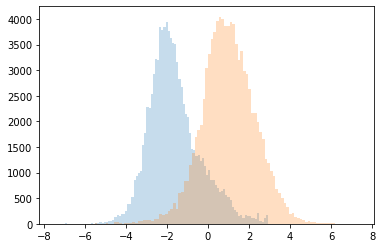

In [32]:
import matplotlib.pyplot as plt


#plt.hist(np.log10(check1.flatten()),bins=100,alpha=0.25)
plt.hist(np.log10(check2.flatten()),bins=100,alpha=0.25)
plt.hist(np.log10(check3.flatten()),bins=100,alpha=0.25)
#plt.hist(np.random.choice(check2.flatten(),1000))